Lecture 5
===========================================================================

Multivariable unconstrained optimisation
------------

In [1]:
from sympy import *
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
init_printing(use_latex='mathjax')

Techniques which require only function values
==========

Downhill Simplex or Sequential Simplex method
------------

A simplex is simply a polytope (multidimensional version of polygon) with n+1 vertices (points) in n dimensional space

In two dimensions, this is a triangle, in three, it is a tetrahedron

The Nelder-Mead version of the simplex algorithm is very commonly implemented in numerical libraries and has the advantage of only needing function values.

In [2]:
x1, x2 = symbols('x1 x2')
f = (x1 - 3)**2 + (x2- 3)**2 + (x1-3)*(x2-3)
f

        2                               2
(x₁ - 3)  + (x₁ - 3)⋅(x₂ - 3) + (x₂ - 3) 

In [3]:
df = [f.diff(m, 1) for m in [x1,x2]]
df

[2⋅x₁ + x₂ - 9, x₁ + 2⋅x₂ - 9]

In [4]:
minxy = solve([df[0], df[1]], [x1, x2])

/usr/lib/pymodules/python2.7/matplotlib/figure.py:371: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


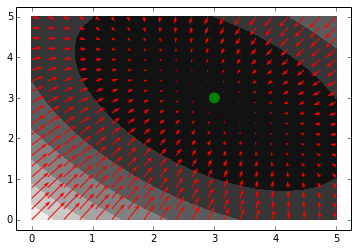

In [5]:
x1a = np.linspace(0.0, 5.0, 20)
x2a = np.linspace(0.0, 5.0, 20)
evalfunc = lambdify((x1,x2), f, modules=['numpy'])
x1a, x2a = np.meshgrid(x1a, x2a)
z1 = evalfunc(x1a,x2a)
df = [f.diff(m, 1) for m in [x1,x2]]
evalfuncdx1 = lambdify((x1,x2), df[0], modules=['numpy'])
evalfuncdx2 = lambdify((x1,x2), df[1], modules=['numpy'])
vx1=-evalfuncdx1(x1a,x2a)
vx2=-evalfuncdx2(x1a,x2a)
fig, ax = plt.subplots()
plt.contourf(x1a, x2a, z1, cmap='binary_r')
plt.scatter(minxy[x1], minxy[x2], s=100, color='green')
ax.quiver(x1a, x2a, vx1, vx2, headwidth=4, headlength=6, color='r')
fig.show()

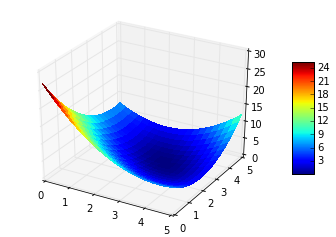

In [6]:
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(x1a, x2a, z1, rstride=1, cstride=1, cmap=cm.jet,
        linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

The minimum must lie between the third last and last x value in the table above.

In [7]:
# simple simplex method implementation - only reflection
def simplex_method(f, alpha, N, simplex0):
    simplex = [simplex0] # initial simplex
    for i in range(N):
        # Evaluate all points in last simplex
        fs = [f.subs([(x1,point[0]),(x2,point[1])]) for point in simplex[-1]]
        # sort points in simplex according to function value (so the last point is the worst)
        sortedsimplex = []
        sortedfs, sortedsimplex = zip(*sorted(zip(fs, simplex[-1])))
        # calculate center of all but last point
        centerx = (sortedsimplex[:-1][0][0] + sortedsimplex[:-1][1][0])/2
        centery = (sortedsimplex[:-1][0][1] + sortedsimplex[:-1][1][1])/2
        reflectedpoint = [0,0]
        reflectedpoint[0] = centerx + alpha*(centerx - sortedsimplex[-1][0])
        reflectedpoint[1] = centery + alpha*(centery - sortedsimplex[-1][1])
        simplex.append(list(sortedsimplex[:-1]) + [tuple(reflectedpoint)])
    return simplex

In [8]:
import matplotlib.patches as patches
from IPython.html.widgets import interact, interactive
from IPython.html import widgets
from IPython.display import display

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [9]:
def show_simplex(alpha, N):
    simplex = simplex_method(f, alpha, N, [(0, 0), (0.2, 0.9), (0.9, 0.2)])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for i in range(np.shape(simplex)[0]):
        poly = patches.Polygon(simplex[i],edgecolor='r', facecolor='b')
        ax.add_patch(poly)
    ax.set_xlim(0,5)
    ax.set_ylim(0,5)
    plt.contourf(x1a, x2a, z1, cmap='binary_r')
    posOpt = (minxy[x1],minxy[x2])
    circ = patches.CirclePolygon(posOpt, radius=0.1, color='Chartreuse')
    ax.add_patch(circ)
    plt.show()

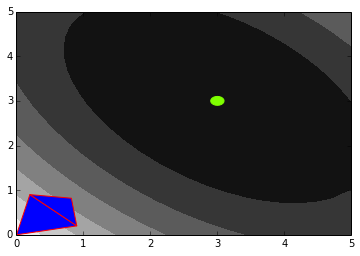

In [11]:
sm = interactive(show_simplex, N=widgets.IntSlider(min=1.0,max=50.0,step=1.0,value=1.0), alpha=(0.0,1.0,0.01))
display(sm)

Conjugate direction search
------------
Vectors $\mathbf{s}^i$ and $\mathbf{s}^j$ are said to conjugate with respect to matrix Q if 

${\mathbf{s}^i}^TQ\mathbf{s}^j=0$

The set of directions which satisfy these equations is known as the nullspace or kernel of the matrix. For optimisation the matrix Q is the Hessian matrix.

Example 6.1:

In [12]:
x1, x2 = symbols('x1 x2')
f = 2*x1**2 + x2**2 - 3
H = hessian(f, [x1,x2])
f, H

⎛    2     2            ⎞
⎜2⋅x₁  + x₂  - 3, ⎡4  0⎤⎟
⎜                 ⎢    ⎥⎟
⎝                 ⎣0  2⎦⎠

Start the search at the point [1,1] with an initial direction ${\mathbf{s}^i}^T$ = [-4,-2]. To find the conjugate direction we determine the nullspace of ${\mathbf{s}^i}^TQ$:

In [29]:
s1 = Matrix([-4, -2]).T
A = s1*H
s1conj = A.nullspace()[0]
s1conj

⎡-1/4⎤
⎢    ⎥
⎣ 1  ⎦

To be consistent with the textbook we multiply this vector by -4, an operation which does not change it. To be sure we can check the original requirement:

In [30]:
s1conj = s1conj*(-4)
s1*H*s1conj

[0]

The original direction and the conjugate directions are indicated on the figure.

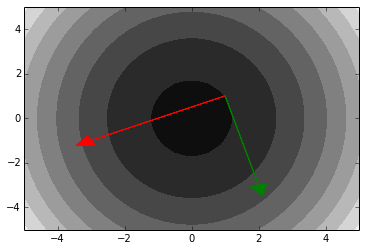

In [31]:
x1a = np.linspace(-5.0, 5.0, 30)
x2a = np.linspace(-5.0, 5.0, 30)
evalfunc = lambdify((x1,x2), f, modules=['numpy'])
x1a, x2a = np.meshgrid(x1a, x2a)
z1 = evalfunc(x1a,x2a)
fig, ax = plt.subplots()
plt.contourf(x1a, x2a, z1, cmap='binary_r')
ax = plt.axes()
ax.arrow(1, 1, -4.0, -2.0, head_width=0.5, head_length=0.5, fc='r', ec='r')
ax.arrow(1, 1, float(s1conj[0]), float(s1conj[1]), head_width=0.5, head_length=0.5, fc='g', ec='g')
fig.show()

To find the optimal value we must take a step in the initial direction:
   ${\mathbf{x}_{new} = \mathbf{x}_{old} + \alpha\mathbf{s}}$

Or for the individual directions:

${{x}_{1,new} = {x}_{1,old} + \alpha{s}_{1}}$

${{x}_{2,new} = {x}_{2,old} + \alpha{s}_{2}}$

To determine the optimal step size we conduct a line search in the initial direction, for convenience we keep the step size fixed as opposed to before when we gradually increased it. 

In [32]:
alpha = 0.01
s0 = Matrix([1.0, 1.0])
spoints = [s0]
newvals = s0 + alpha * s1.T
spoints.append(newvals)
k = 1
while f.subs([(x1,spoints[k][0]),(x2,spoints[k][1])]) <  f.subs([(x1,spoints[k-1][0]),(x2,spoints[k-1][1])]):
    k = k + 1
    newvals = s0 + alpha * k * s1.T
    spoints.append(newvals)

print alpha * k    

0.29


The search indicates that we will be at the minimum value of f along the direction ${\mathbf{s}^i}^T$ = [-4,-2] if we multiply this vector by 0.29, this makes the new starting point:

In [33]:
s2 = s0 + alpha * k * s1.T
s2

⎡-0.16⎤
⎢     ⎥
⎣0.42 ⎦

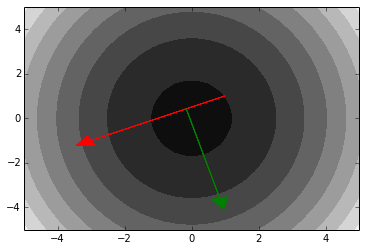

In [34]:
fig, ax = plt.subplots()
plt.contourf(x1a, x2a, z1, cmap='binary_r')
ax = plt.axes()
ax.arrow(1, 1, -4.0, -2.0, head_width=0.5, head_length=0.5, fc='r', ec='r')
ax.arrow(s2[0], s2[1], float(s1conj[0]), float(s1conj[1]), head_width=0.5, head_length=0.5, fc='g', ec='g')
fig.show()

Performing another line search in the conjugate direction from this new starting point:

In [38]:
alpha = 0.01
spoints = [s2]
newvals = s2 + alpha * s1conj
spoints.append(newvals)
k = 1
while f.subs([(x1,spoints[k][0]),(x2,spoints[k][1])]) <  f.subs([(x1,spoints[k-1][0]),(x2,spoints[k-1][1])]):
    k = k + 1
    newvals = s2 + alpha * k * s1conj
    spoints.append(newvals)

print alpha * k   

0.12


Thus if we multiply the conjugate vector by 0.12 and add it to the starting point we obtain the optimal value:

In [39]:
s2 + alpha * k * s1conj

⎡-0.0399999999999999⎤
⎢                   ⎥
⎣-0.0599999999999999⎦

This is very close to the true optimum of (0,0), to obtain a better value smaller steps of ${\alpha}$ could be used. The reason we achieve the optimal solution in only two steps is because the function is quadratic.

Techniques which require function derivatives
==========

Conjugate gradient search
------------
This approach combines the use of conjugate directions with the use of the gradient 


Newton's method
------------
This approach combines the use of conjugate directions with the use of the gradient 
